In [ ]:
1. read SDS between two dates
2. apply psi to feet correction
3. plot all 6S on a single axes, and same for 6I
4. 

/mnt/RAIDZ/share/data/KSC/EROSION/EVENTS/20220724T133820_raw.pkl


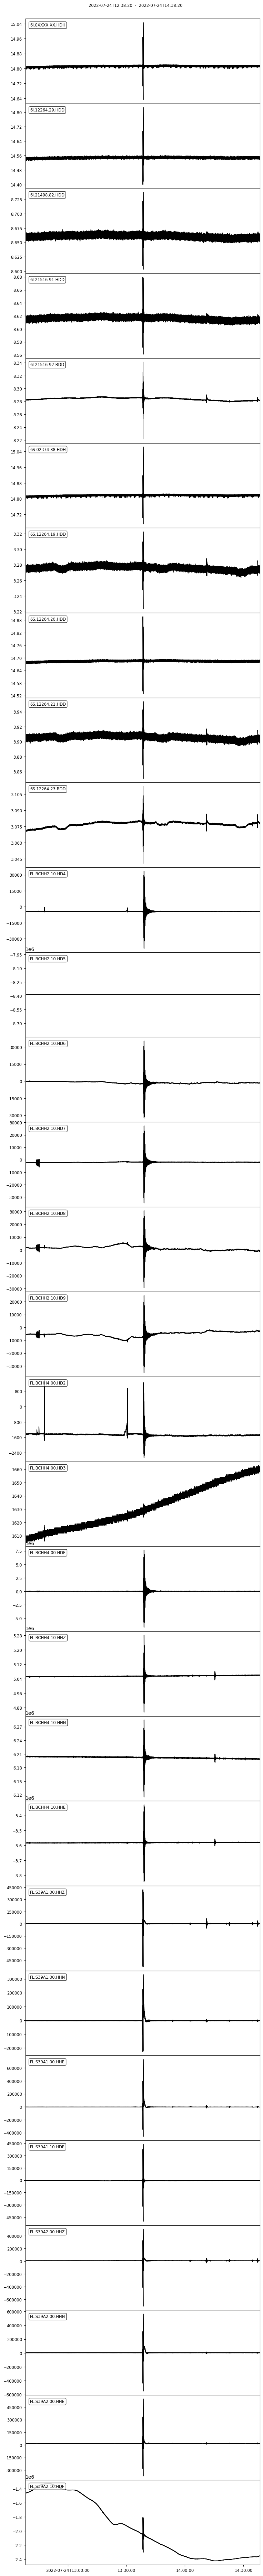

In [4]:
import obspy 
from tkinter import filedialog as fd
DIR = '/home/thompsong/work/PROJECTS/KSC_EROSION/EVENTS'
#DIR = '/home/thompsong/work/PROJECTS/KSC_EROSION/SDS/2022'
file = fd.askopenfile(initialdir = DIR)
print(file.name)
st = obspy.read(file.name, format='PICKLE')
st.plot(equal_scale=False);

In [ ]:
import os, sys
import numpy as np
sys.path.append( os.environ['ANTELOPE'] + '/data/python' )
import antelope.datascope as datascope
dbptr = datascope.dbopen('/opt/antelope/data/db/demo/demo', 'r')
dbtableptr = dbptr.lookup(table = 'wfdisc')
iter = dbtableptr.iter_record()
print(iter)
print(iter.get())
print(next(iter))
print(iter.get())

dbviewptr = dbtableptr.subset('sta == "B082A"')

trptr = dbviewptr.trload_css("1452569317.55000", "1452569421.00000")
print(trptr)
trptr.trapply_calib()
trptr.record = 0
tr = obspy.Trace(data=np.array(trptr.trdata()))
trptr.free()
dbviewptr.free()
dbptr.free()
tr.plot()

In [3]:
import os, sys
import numpy as np
import obspy
sys.path.append( os.environ['ANTELOPE'] + '/data/python' )
import antelope.datascope as datascope
import time

def db2Stream(dbpath, stime, etime):
    st = obspy.Stream()
    if os.path.isfile(dbpath):
        dbptr = datascope.dbopen(dbpath, 'r')
    else:
        print(dbpath, ' not found')
        print('pwd=',os.getcwd())
        return
    sepoch = stime.timestamp
    eepoch = etime.timestamp
    #print(stime, etime, sepoch, eepoch)

    dbtableptr = dbptr.lookup(table = 'wfdisc')
    nr = dbtableptr.query("dbRECORD_COUNT")
    #print('Number of records: ',nr)
    st = obspy.Stream()
    # NOT WORKING. MAYBE TRY trload_cssgrp?
    for dbtableptr.record in range(1):
        sta, chan, time, samprate, calib = dbtableptr.getv('sta','chan', 'time', 'samprate', 'calib')
        trptr = dbtableptr.trload_css(f"{sepoch}", f"{eepoch}")
        nrt = trptr.query("dbRECORD_COUNT")
        #print(trptr)
        #trptr.trapply_calib()
        for trptr.record in range(nrt):
            sta, chan, time, samprate, calib = trptr.getv('sta','chan', 'time', 'samprate', 'calib')
            #print(trptr.record, sta, chan, time)
            if len(sta)>5:
                sta = sta[0:5]
            #print(trptr.get())
            tr = obspy.Trace(data=np.array(trptr.trdata()))
            tr.stats.delta = 1/samprate
            tr.stats.station = sta
            tr.stats.channel = chan[0:3]
            if len(chan)>3:
                tr.stats.location = chan[4:]
            #tr.stats.calib = calib
            tr.stats.starttime = stime
            st.append(tr)
        trptr.free()
    dbptr.free()
    st.merge(method=0, fill_value=0)
    return st

import glob
def mseed2Stream(mseedpath, stime, etime):
    yyyy = stime.strftime('%Y')
    jday  = stime.strftime('%j')
    files = glob.glob(os.path.join(mseedpath, yyyy, '*', '*', '[HBC]*.D', f'*{jday}'))
    st = obspy.Stream()
    for f in files:
        this_st = obspy.read(f, format='MSEED')
        this_st.trim(starttime=stime, endtime=etime)
        this_st.merge(method=0, fill_value=0)
        for tr in this_st:
            st.append(tr)
    return st

def get_trlist(st):
    for tr in st:
        tr.stats.network=''
    trlist = sorted([tr.id for tr in st])
    return trlist

# Test 1
launchtime = obspy.UTCDateTime(2022,7,24,13,38,0)
pretrig = 60
posttrig = 200
stime = launchtime - pretrig
etime = launchtime + posttrig
time1 = time.time()
dbpath = f'/home/thompsong/work/PROJECTS/KSC_EROSION/db/db{stime.strftime("%Y%m%d")}'
st = db2Stream(dbpath, stime, etime)
time2 = time.time()
trlist1 = get_trlist(st)
print('db2Stream took ',time2-time1)
#st.write('test.mseed','MSEED')
#st.plot(equal_scale=False);

# Test 2
time1 = time.time()
mseedpath = '/home/thompsong/work/PROJECTS/KSC_EROSION/SDS'
st = mseed2Stream(mseedpath, stime, etime)
time2 = time.time()
trlist2 = get_trlist(st)
print('mseed2Stream took ',time2-time1)

# Test 3
from obspy.clients.filesystem.sds import Client
sdsclient = Client(mseedpath)
#sdsclient.get_all_nslc(sds_type=None, datetime=stime)
time1 = time.time()
st = sdsclient.get_waveforms("*", "*", "*", "[HD]*", stime, etime)
time2 = time.time()
trlist3 = get_trlist(st)
print('sdsclient.get_waveforms took ',time2-time1)

# Test 4
import header
paths = header.setup_environment()
import SDS
paths['SDS_TOP'] = os.path.join(paths['outdir'], 'SDS')
thisSDSobj = SDS.SDSobj(paths['SDS_TOP'])
time1 = time.time()
thisSDSobj.read(stime, etime, speed=1)
time2 = time.time()
print('SDS class took ',time2-time1) 
trlist4 = get_trlist(st)

def compare_trace_ids(trlist1, trlist2, testA=1, testB=2):
    same = True
    for trid in trlist1:
        if not trid in trlist2:
            same = False
            print(trid,' in %d, not in %d' % (testA, testB))
    for trid in trlist2:
        if not trid in trlist1:
            same = False
            print(trid,' in %d, not in %d' % (testB, testA))
    if same:
        print('%d and %d are same' % (testA, testB))
            
compare_trace_ids(trlist1, trlist2, testA=1, testB=2)
compare_trace_ids(trlist3, trlist2, testA=3, testB=2)
compare_trace_ids(trlist4, trlist2, testA=4, testB=2)

#st.select(id='.12264.23.BDD').plot(equal_scale=False);
#st.select(id='.21516.92.BDD').plot(equal_scale=False);

db2Stream took  0.08658409118652344
mseed2Stream took  4.831359386444092
sdsclient.get_waveforms took  1.2187507152557373
st = read("/home/thompsong/work/PROJECTS/KSC_EROSION/SDS/2022/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.2022.205")
st = read("/home/thompsong/work/PROJECTS/KSC_EROSION/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.205")
st = read("/home/thompsong/work/PROJECTS/KSC_EROSION/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.205")
st = read("/home/thompsong/work/PROJECTS/KSC_EROSION/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.205")
st = read("/home/thompsong/work/PROJECTS/KSC_EROSION/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.205")
st = read("/home/thompsong/work/PROJECTS/KSC_EROSION/SDS/2022/6S/02374/HDH.D/6S.02374.88.HDH.D.2022.205")
st = read("/home/thompsong/work/PROJECTS/KSC_EROSION/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.205")
st = read("/home/thompsong/work/PROJECTS/KSC_EROSION/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.205")
st = read("/home/thompsong/wor